In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

data_dir = '../data/'


In [2]:
print('loading prior orders')
prior_orders = pd.read_csv(data_dir + 'order_products__prior.csv', dtype={
        'order_id': np.int32,
        'product_id': np.int32,
        'add_to_cart_order': np.int16,
        'reordered': np.int8})
print('loading orders')
orders = pd.read_csv(data_dir + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})
print('loading aisles info')
products = pd.read_csv(data_dir + 'products.csv', engine='c',
                           usecols = ['product_id','aisle_id'],
                       dtype={'product_id': np.int32, 'aisle_id': np.int32})
aisles = pd.read_csv(data_dir+'aisles.csv',
                    dtype={
                        'aisle_id':np.int32,
                        'aisle':np.str
                    })
pd.set_option('display.float_format', lambda x: '%.3f' % x)

loading prior orders
loading orders
loading aisles info


Get prior order buckets

In [3]:
num_orders = prior_orders.groupby('product_id').order_id.count()

plot iqr of orders by product_id

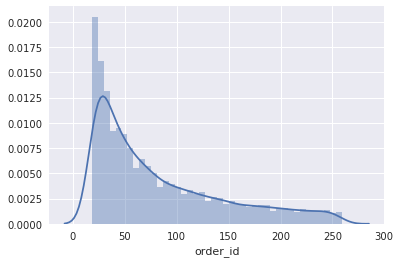

In [4]:
num_orders.describe()
iqr = num_orders.quantile([.25,.75]).values
sns.distplot(num_orders.apply(lambda x: x if (x>iqr[0] and x<iqr[1]) else None).dropna())

Look at reorder rate

In [5]:
## first drop all orders that have no reorder items, assuming this might be the first order or just are not typical
reorder_rate = prior_orders.groupby('order_id').reordered.sum()
# Look at top 5 
print(reorder_rate.value_counts()[:5])
reorder_rate = reorder_rate.to_frame()

0.000    388513
2.000    330770
1.000    327898
3.000    312493
4.000    281704
5.000    246626
Name: reordered, dtype: int64


In [6]:
index_list = reorder_rate[reorder_rate['reordered']==0].index
reorder_rate = prior_orders[~prior_orders['order_id'].isin(index_list)]
reorder_rate = reorder_rate.groupby('product_id').reordered.sum()
reorder_rate.describe()

count    49612.000
mean       385.522
std       3604.045
min          0.000
25%          4.000
50%         22.000
75%        116.000
max     398609.000
Name: reordered, dtype: float64

Drop IQR again


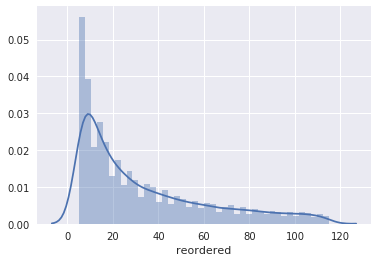

In [7]:
iqr = reorder_rate.quantile([.25,.75]).values
sns.distplot(reorder_rate.apply(lambda x: x if (x>iqr[0] and x<iqr[1]) else None).dropna())

Try to do some user segmentation on order amounts as well as days inbetween


In [8]:
user_orders = orders.groupby(['user_id']).order_id.count()
user_orders.describe()

count   206209.000
mean        16.590
std         16.655
min          4.000
25%          6.000
50%         10.000
75%         20.000
max        100.000
Name: order_id, dtype: float64

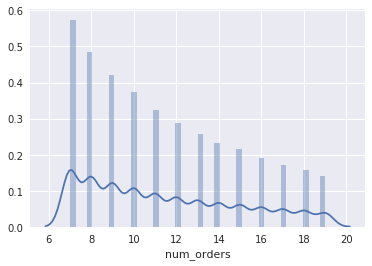

In [9]:
iqr = user_orders.quantile([.25,.75]).values
sns.distplot(user_orders.apply(lambda x: x if (x>iqr[0] and x<iqr[1]) else None).dropna(), axlabel='num_orders')

Look at product purchases by aisles and departments

In [10]:
prod_by_aisle = products.merge(aisles,on='aisle_id')

Look at main Categories

In [17]:
prior_orders.merge(prod_by_aisle,on='product_id').aisle.value_counts()[:10]

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
Name: aisle, dtype: int64

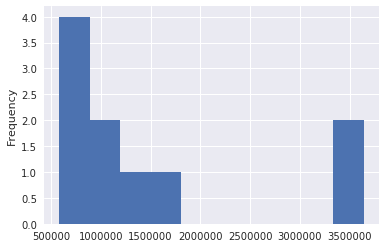

In [16]:
prior_orders.merge(prod_by_aisle,on='product_id').aisle.value_counts()[:10].plot(kind='hist')

Try to use PCA to segment user groups Since there is significant drops after milk I will use 6 at first

In [20]:
aisle_with_prior = prior_orders.merge(prod_by_aisle,on='product_id').merge(orders,on='order_id')


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
crosstab_on_aisle = pd.crosstab(aisle_with_prior.user_id,aisle_with_prior.aisle)
pca.fit(crosstab_on_aisle)